In [1]:
import tomllib

import ehc_sn as ehc
import matplotlib.pyplot as plt
import torch

import plots

In [2]:
with open("configurations/balanced_network.toml", "rb") as f:
    data = tomllib.load(f)

In [3]:
parameters = ehc.Parameters.model_validate(data)
model = ehc.EINetwork(p=parameters)
model = torch.compile(model)
model.eval()

OptimizedModule(
  (_orig_mod): EINetwork(
    (excitatory): EILayer(
      (neurons): BaseLayer(p=LIFRefracParameters(lif=LIFParameters(tau_syn_inv=tensor(10., device='cuda:0'), tau_mem_inv=tensor(4., device='cuda:0'), v_leak=tensor(-40., device='cuda:0'), v_th=tensor(-50., device='cuda:0'), v_reset=tensor(-60., device='cuda:0'), method='super', alpha=tensor(0.5000, device='cuda:0')), rho_reset=tensor(5, device='cuda:0')), dt=0.001)
      (ampa): Inputs()
      (gaba): Inputs()
    )
    (inhibitory): EILayer(
      (neurons): BaseLayer(p=LIFRefracParameters(lif=LIFParameters(tau_syn_inv=tensor(10., device='cuda:0'), tau_mem_inv=tensor(4., device='cuda:0'), v_leak=tensor(-60., device='cuda:0'), v_th=tensor(-50., device='cuda:0'), v_reset=tensor(-60., device='cuda:0'), method='super', alpha=tensor(0.5000, device='cuda:0')), rho_reset=tensor(5, device='cuda:0')), dt=0.001)
      (ampa): Inputs()
      (gaba): Inputs()
    )
  )
)

In [4]:
decoder = ehc.decoders.HannDecoder(window_length=100)
ymin, ymax = 0, 200

In [5]:
def signal_loader(n, i=0.0, xmin=0, xmax=200):
    x = torch.zeros(800, device=ehc.device).detach()
    x[xmin:xmax] = i
    for _ in range(n):
        yield x

In [6]:
for x in signal_loader(1000, i=0.0, xmax=200):
    model(x)

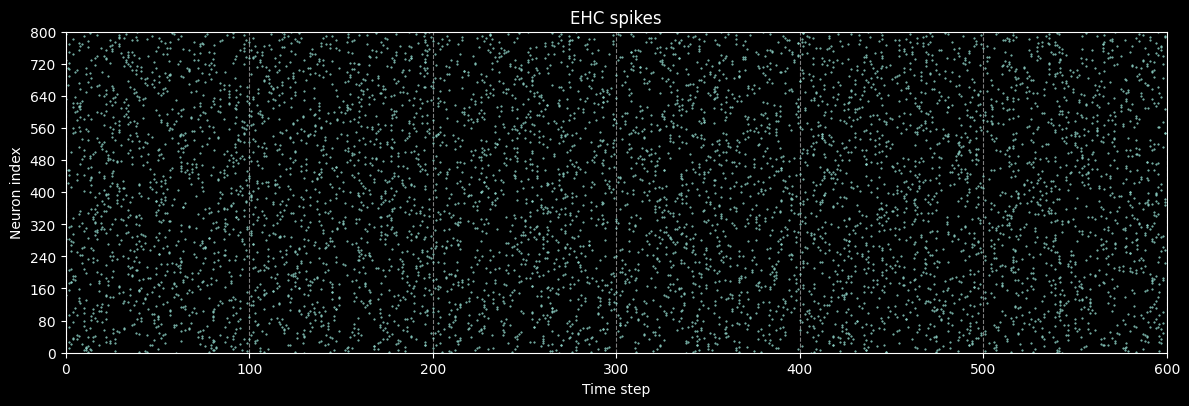

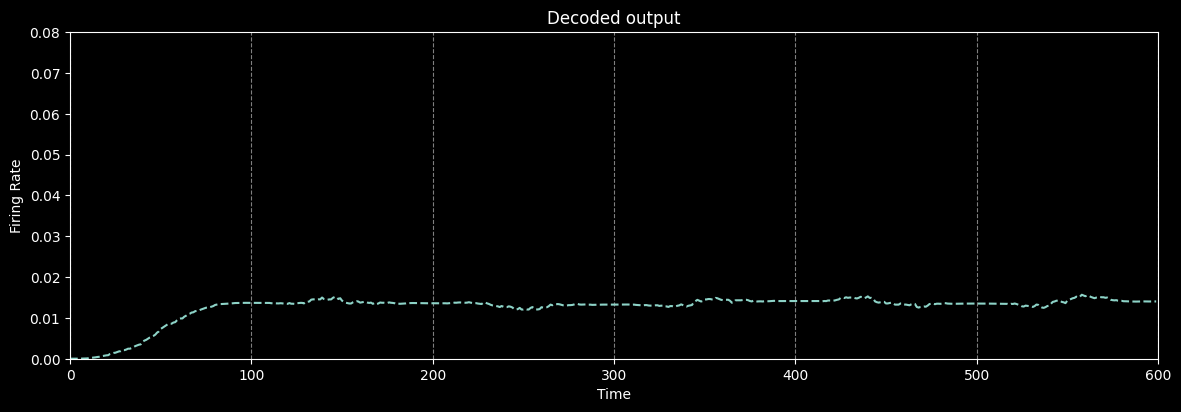

In [7]:
spikes_out = [model(x) for x in signal_loader(600, i=0.0, xmax=200)]
spikes_out = torch.stack(spikes_out)  # Stack spikes in tensor
plots.raster(spikes_out.cpu(), markersize=1)
plt.title("EHC spikes")
plt.show()

signal_out = torch.stack([decoder(x) for x in spikes_out[:, ymin:ymax]])
signal_out = signal_out.mean(dim=1).unsqueeze(1).detach()
plots.signal(signal_out.cpu())
plt.title("Decoded output"), plt.ylim(0.0, 0.080)
plt.show()

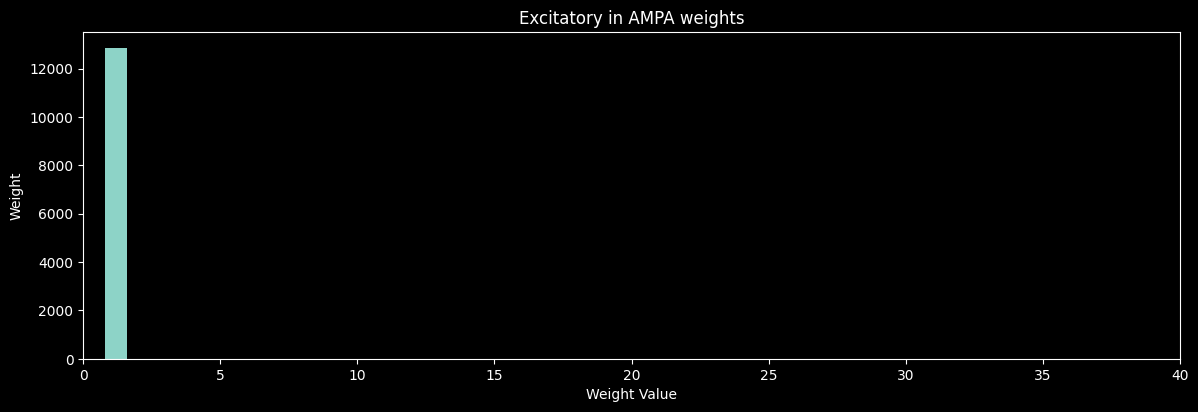

In [8]:
w = model.excitatory.ampa.w.detach().cpu()
mask = model.excitatory.ampa.mask.detach().cpu()
filtered_weights = w.masked_select(mask)
plots.weights(filtered_weights, range=[0, 40])
plt.title("Excitatory in AMPA weights"), plt.xlim(0, 40)
plt.show()

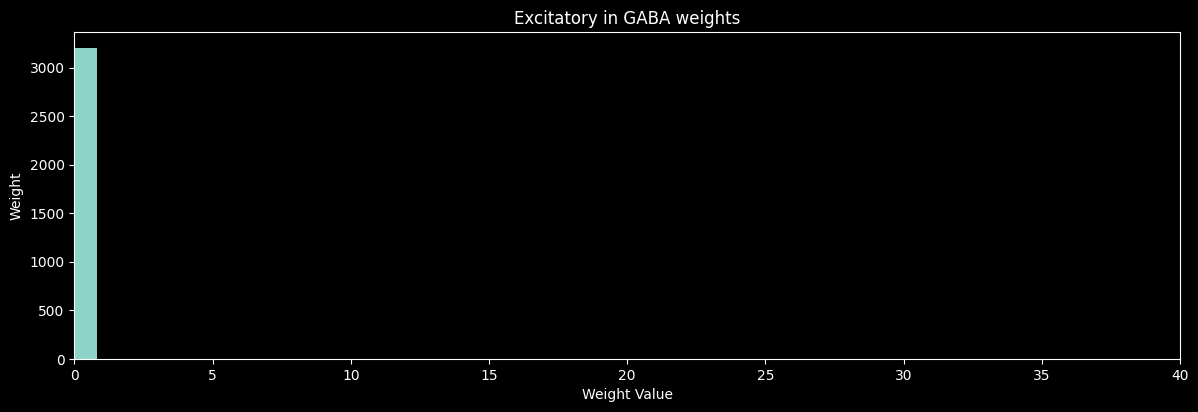

In [9]:
w = model.excitatory.gaba.w.detach().cpu()
mask = model.excitatory.gaba.mask.detach().cpu()
filtered_weights = w.masked_select(mask)
plots.weights(filtered_weights, range=[0, 40])
plt.title("Excitatory in GABA weights"), plt.xlim(0, 40)
plt.show()

In [10]:
for x in signal_loader(20000, i=1.0, xmax=200):
    model(x)

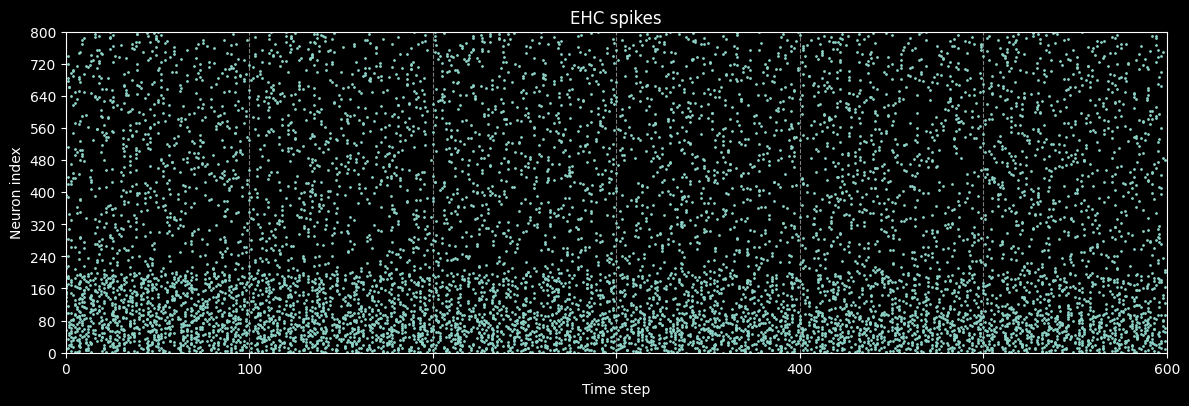

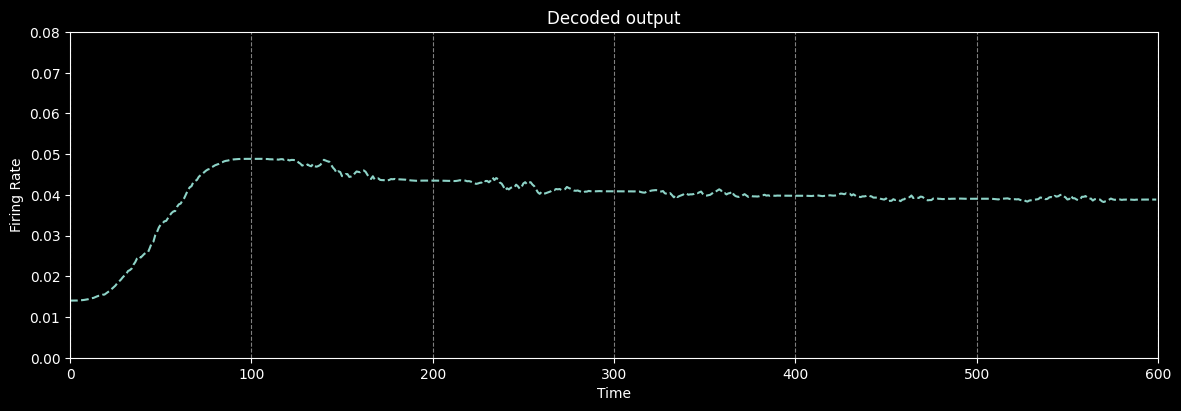

In [11]:
spikes_out = [model(x) for x in signal_loader(600, i=1.0, xmax=100)]
spikes_out = torch.stack(spikes_out)  # Stack spikes in tensor
plots.raster(spikes_out.cpu(), markersize=2)
plt.title("EHC spikes")
plt.show()

signal_out = torch.stack([decoder(x) for x in spikes_out[:, ymin:ymax]])
signal_out = signal_out.mean(dim=1).unsqueeze(1).detach()
plots.signal(signal_out.cpu())
plt.title("Decoded output"), plt.ylim(0.0, 0.080)
plt.show()

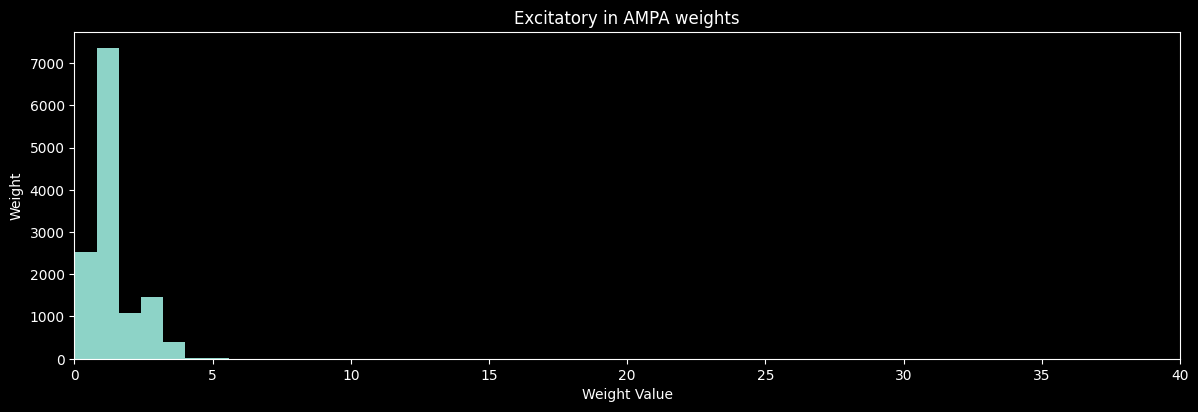

In [12]:
w = model.excitatory.ampa.w.detach().cpu()
mask = model.excitatory.ampa.mask.detach().cpu()
filtered_weights = w.masked_select(mask)
plots.weights(filtered_weights, range=[0, 40])
plt.title("Excitatory in AMPA weights"), plt.xlim(0, 40)
plt.show()

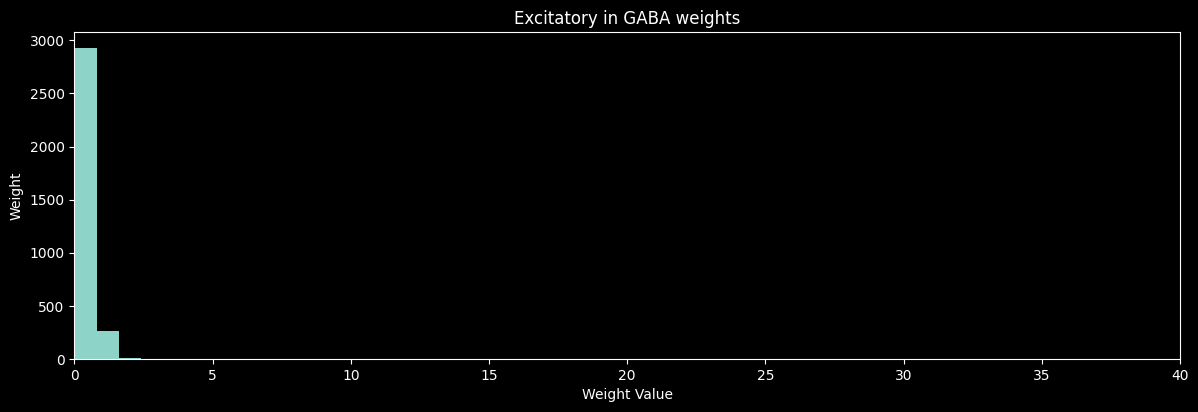

In [13]:
w = model.excitatory.gaba.w.detach().cpu()
mask = model.excitatory.gaba.mask.detach().cpu()
filtered_weights = w.masked_select(mask)
plots.weights(filtered_weights, range=[0, 40])
plt.title("Excitatory in GABA weights"), plt.xlim(0, 40)
plt.show()